In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction import text

import functions as fun
from lists import expanded_stopwords, expanded_proper_names

import time

In [2]:
whole_df = pd.read_csv('data/cleaned_all_text2022-06-29.csv')

whole_df.head()

,created_utc,selftext,subreddit_name,title,all_words,submission_length,title_length,submission_word_count,title_word_count,no_selftext,avg_word_length
0,1656261965,[removed],startrek,Which version of Klingons will appear in SNW?,Which version of Klingons will appear in SNW?,9.0,45.0,1.0,8.0,0.0,4.625000
1,1656254308,[removed],startrek,On the Gorn and language,On the Gorn and language,9.0,24.0,1.0,5.0,0.0,4.000000
2,1656248567,[removed],startrek,What are some good things that can be said abo...,What are some good things that can be said abo...,9.0,61.0,1.0,13.0,0.0,3.692308
3,1656238740,[removed],startrek,A Lord of the Rings reference in SNW 1x08,A Lord of the Rings reference in SNW 1x08,9.0,41.0,1.0,9.0,0.0,3.333333
4,1656238132,[removed],startrek,The sword props used in SNW 1x08 are replicas ...,The sword props used in SNW 1x08 are replicas ...,9.0,119.0,1.0,22.0,0.0,4.090909


In [3]:
df = whole_df[['subreddit_name', 'all_words']]

# Baseline Accuracy

Our baseline accuracy is 50.9%

In [4]:
df.subreddit_name.value_counts(normalize = True)

startrek    0.509214
starwars    0.490786
Name: subreddit_name, dtype: float64

# Prepping Data for Modeling

Getting training and test data set up.

In [5]:
X = df['all_words']
y = df['subreddit_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('')
print('Dataframe shape:', df.shape)
print('')
print('y_train value counts:', y_train.value_counts(normalize = True))
print('y_test value counts:', y_test.value_counts(normalize = True))

X_train shape: (5209,)
y_train shape: (5209,)
X_test shape: (1737,)
y_test shape: (1737,)

Dataframe shape: (6946, 2)

y_train value counts: startrek    0.509119
starwars    0.490881
Name: subreddit_name, dtype: float64
y_test value counts: startrek    0.509499
starwars    0.490501
Name: subreddit_name, dtype: float64


-----

# Best Models
NOTE: As mentioned before, these are the best models after taking out show specific names/words to make the model more challenging to build.

## Model 8, TfidifVectorizer, MultinomialNB, 'no_selftext' Feature Included
Best overall performance.

In [6]:
# Model 8 Best Version
X = whole_df.drop(columns = 'subreddit_name')
y = whole_df['subreddit_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

tvec = TfidfVectorizer(max_df=0.7, max_features=4_800, stop_words = expanded_proper_names)
vectorized_train = tvec.fit_transform(X_train['all_words'])
vectorized_test = tvec.transform(X_test['all_words'])

vectorized_train = pd.DataFrame(vectorized_train.todense(), columns = tvec.get_feature_names_out())
vectorized_test = pd.DataFrame(vectorized_test.todense(), columns = tvec.get_feature_names_out())

print('vectorized_train shape:', vectorized_train.shape)
print('vectorized_test shape:', vectorized_test.shape)

X_train = X_train.reset_index()
X_test = X_test.reset_index()

print('X_train reset index shape:', X_train.shape)
print('X_test reset index shape:', X_test.shape)

vectorized_train = pd.concat([X_train[['index', 'no_selftext']], vectorized_train], axis = 1)
vectorized_test = pd.concat([X_test[['index', 'no_selftext']], vectorized_test], axis = 1)

print('vectorized_train concatenated shape:', vectorized_train.shape)
print('vectorized_test concatenated shape:', vectorized_test.shape)

vectorized_train = vectorized_train.set_index('index')
vectorized_test = vectorized_test.set_index('index')

print('vectorized_train corrected index shape:', vectorized_train.shape)
print('vectorized_test corrected index shape:', vectorized_test.shape)

nb = MultinomialNB(alpha=0.2)

nb.fit(vectorized_train, y_train)

print('Training score:', nb.score(vectorized_train, y_train))
print('Test score:', nb.score(vectorized_test, y_test))

X_train shape: (5209, 10)
X_test shape: (1737, 10)
y_train shape: (5209,)
y_test shape: (1737,)
vectorized_train shape: (5209, 4800)
vectorized_test shape: (1737, 4800)
X_train reset index shape: (5209, 11)
X_test reset index shape: (1737, 11)
vectorized_train concatenated shape: (5209, 4802)
vectorized_test concatenated shape: (1737, 4802)
vectorized_train corrected index shape: (5209, 4801)
vectorized_test corrected index shape: (1737, 4801)
Training score: 0.9249376079861777
Test score: 0.8733448474381117


## Model 9: TfidfVectorizer, LogisticRegression, 'no_selftext' Feature Included
Best Logistic Regression Performance

In [7]:
# BEST RESULT

X = whole_df.drop(columns = 'subreddit_name')
y = whole_df['subreddit_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

tvec = TfidfVectorizer(max_df=0.12, max_features=6_500, ngram_range=(1,2), stop_words = expanded_stopwords)
vectorized_train = tvec.fit_transform(X_train['all_words'])
vectorized_test = tvec.transform(X_test['all_words'])

vectorized_train = pd.DataFrame(vectorized_train.todense(), columns = tvec.get_feature_names_out())
vectorized_test = pd.DataFrame(vectorized_test.todense(), columns = tvec.get_feature_names_out())

print('vectorized_train shape:', vectorized_train.shape)
print('vectorized_test shape:', vectorized_test.shape)

X_train = X_train.reset_index()
X_test = X_test.reset_index()

print('X_train reset index shape:', X_train.shape)
print('X_test reset index shape:', X_test.shape)

vectorized_train = pd.concat([X_train[['index', 'no_selftext']], vectorized_train], axis = 1)
vectorized_test = pd.concat([X_test[['index', 'no_selftext']], vectorized_test], axis = 1)

print('vectorized_train concatenated shape:', vectorized_train.shape)
print('vectorized_test concatenated shape:', vectorized_test.shape)

vectorized_train = vectorized_train.set_index('index')
vectorized_test = vectorized_test.set_index('index')

print('vectorized_train corrected index shape:', vectorized_train.shape)
print('vectorized_test corrected index shape:', vectorized_test.shape)

log = LogisticRegression(max_iter=10_000, C=1.4)

log.fit(vectorized_train, y_train)

print('Training score:', log.score(vectorized_train, y_train))
print('Test score:', log.score(vectorized_test, y_test))

X_train shape: (5209, 10)
X_test shape: (1737, 10)
y_train shape: (5209,)
y_test shape: (1737,)
vectorized_train shape: (5209, 6500)
vectorized_test shape: (1737, 6500)
X_train reset index shape: (5209, 11)
X_test reset index shape: (1737, 11)
vectorized_train concatenated shape: (5209, 6502)
vectorized_test concatenated shape: (1737, 6502)
vectorized_train corrected index shape: (5209, 6501)
vectorized_test corrected index shape: (1737, 6501)
Training score: 0.9149548857746208
Test score: 0.8480138169257341


# Examining Coefficients from Logistic Regression

I referenced the Logistic Regression exercise from lesson 4.04 to help with writing the code for this analysis. 

In [13]:
vectorized_train['new worlds']

index
339     0.0
433     0.0
816     0.0
329     0.0
6426    0.0
       ... 
966     0.0
6379    0.0
4166    0.0
2159    0.0
2375    0.0
Name: new worlds, Length: 5209, dtype: float64

In [8]:
coefs = pd.DataFrame(zip(vectorized_train.columns, log.coef_[0]))
coefs = coefs.rename(columns = {0:'feature', 1:'coefficient'})
coefs.head()

,feature,coefficient
0,no_selftext,1.883701
1,01,-0.402897
2,04,-0.095423
3,05,-0.058018
4,06,0.225643


# Intepreting Coefficients
NOTE: 'new worlds' appears because the vectorizer optimized for 1- and 2-grams. I'd weighed removing 'new' and 'worlds' because of their appearance in the title of 'Strange New Worlds' but opted against it because they're such common words. It appears that the appearance of 'Strange New Worlds' ('strange' removed using the expanded stopword list) left behind a lot of 'new worlds'. Interestingly, 'worlds' alone still appears at the top of the list but 'new' doesn't appear in the top 50 words by itself, suggesting that there are plenty of references to 'worlds' by itself.

I referenced [this article](https://quantifyinghealth.com/interpret-logistic-regression-coefficients/) which I've found helpful before to help in making sure I was interpreting log odds correctly.

Many of the words that appear here are not surprising: they're franchise-specific proper names or terms, or they reflect the relative balance of TV verus movies (Star Trek having started on TV and migrated to the movies, and Star Wars having started in movies and migrated to TV). There were a few notable standouts, to me.

Examining the top 10 for Star Trek, there are two words that stand out: firstly, 'crew'. 'crew' is fairly franchise specific in that every ship in the franchise has a crew, but I think its usage in the franchise and large effect on the model (the appearance of the word 'crew' makes it 19.5 times as likely a post is a Star Trek post, everything else held equal) reflects a lot on the nature of the show and on what its subredditors discuss, relative to Star Wars subredditors.

Even more fascinating to me is that the word 'love' was in the top 10 most impactful words in the model. The appearance of the word 'love' made it 7.7 times as likely that a post was a Star Trek post and not a Star Wars post, everything else held equal.

Pair that with the non-proper name, etc., terms in the Star Wars top 10, and some important differences between the two subreddits (and the two sets of subredditors) appear.

The single most predictive word for Star Wars is 'fight'. It's appearance makes it 17.9 times as likely that a post is a Star Wars post, all else held equal. There's only one other top 10 word that isn't a proper name or reflection of the TV/movie balance ('prequels' refers to a specific set of films, and 'finale' is in the Star Wars list because the finale of the Obi-Wan Kenobi series [aired on June 22, 2022](https://www.msn.com/en-gb/entertainment/tv/how-to-watch-obi-wan-kenobi-episode-6-online-right-now-finale-release-date-time-and-episode-schedule/ar-AAYDmOM), three days before I pulled this data). That other word is the word 'kill', the presence of which in a post makes it 10.7 times as likely it's a Star Wars post, all else held equal.

It's certainly possible that the contrast of these two sets of words ('crew' and 'love' versus 'fight' and 'kill') is reflective of a specific moment in the two franchises. I'm not up on all the newest Star Trek episodes (particularly 'Strange New Worlds', which is midseason) and I haven't watched Obi-Wan Kenobi. It's certainly possible the appearance of these two words is reflective of current story lines and not of how subredditors write about the franchises on a consistent basis.

My suspicion is that these differences reflect a difference in the subreddits and a difference in the appeal of the two different franchises. After all, one is 'Trek' and the other is 'Wars', but more research is needed to verify that. One possible avenue to that would be to select a variety of posts of a greater range of time and see if the same words appear near the top.

In [14]:
st_top_10 = coefs.sort_values('coefficient').head(10)
st_top_10['odds_ratio_sw']=np.exp(st_top_10['coefficient'])
st_top_10['odds_ratio_st']= 1/st_top_10['odds_ratio_sw']
st_top_10

,feature,coefficient,odds_ratio_sw,odds_ratio_st
3920,new worlds,-5.660487,0.003481,287.288463
6400,worlds,-3.966570,0.018938,52.803112
1300,crew,-2.972395,0.051181,19.538651
3149,khan,-2.598901,0.074355,13.448944
6087,uss,-2.366303,0.093827,10.657917
5007,season,-2.181639,0.112856,8.860814
4503,queen,-2.048758,0.128895,7.758258
3502,love,-2.037623,0.130338,7.672349
2404,generation,-2.001558,0.135125,7.400574
4423,prodigy,-1.989492,0.136765,7.311820


In [15]:
st_top_50 = coefs.sort_values('coefficient').head(50)
st_top_50['odds_ratio_sw']=np.exp(st_top_50['coefficient'])
st_top_50['odds_ratio_st']= 1/st_top_50['odds_ratio_sw']
st_top_50

,feature,coefficient,odds_ratio_sw,odds_ratio_st
3920,new worlds,-5.660487,0.003481,287.288463
6400,worlds,-3.966570,0.018938,52.803112
1300,crew,-2.972395,0.051181,19.538651
3149,khan,-2.598901,0.074355,13.448944
6087,uss,-2.366303,0.093827,10.657917
5007,season,-2.181639,0.112856,8.860814
4503,queen,-2.048758,0.128895,7.758258
3502,love,-2.037623,0.130338,7.672349
2404,generation,-2.001558,0.135125,7.400574
4423,prodigy,-1.989492,0.136765,7.311820


In [16]:
sw_top_10 = coefs.sort_values('coefficient').tail(10)
sw_top_10['odds_ratio_sw']=np.exp(sw_top_10['coefficient'])
sw_top_10 = sw_top_10.sort_values('coefficient', ascending = False)
sw_top_10

,feature,coefficient,odds_ratio_sw
2195,fight,2.883294,17.873043
5425,starwars,2.843267,17.171771
2232,finale,2.690944,14.745585
293,ahsoka,2.598844,13.448185
3812,movies,2.480755,11.950278
4870,rogue,2.452423,11.616463
5595,sw,2.396440,10.984007
3159,kill,2.368769,10.684227
4376,prequels,2.364331,10.636918
4819,revenge,2.336247,10.342348


In [12]:
sw_top_50 = coefs.sort_values('coefficient').tail(50)
sw_top_50['odds_ratio_sw']=np.exp(sw_top_50['coefficient'])
sw_top_50 = sw_top_50.sort_values('coefficient', ascending = False)
sw_top_50

,feature,coefficient,probability
2195,fight,2.883294,17.873043
5425,starwars,2.843267,17.171771
2232,finale,2.690944,14.745585
293,ahsoka,2.598844,13.448185
3812,movies,2.480755,11.950278
4870,rogue,2.452423,11.616463
5595,sw,2.396440,10.984007
3159,kill,2.368769,10.684227
4376,prequels,2.364331,10.636918
4819,revenge,2.336247,10.342348


In [26]:
impt_st = pd.concat([st_top_10[(st_top_10['feature']== 'crew')], st_top_10[st_top_10['feature']== 'love']])
print("Star Trek Word shape", impt_st.shape)
impt_sw = pd.concat([sw_top_10[(sw_top_10['feature']== 'fight')], sw_top_10[sw_top_10['feature']== 'kill']])
print("Star Wars Word shape", impt_sw.shape)

Star Trek Word shape (2, 4)
Star Wars Word shape (2, 3)


In [72]:
impt_st.iloc[0]['odds_ratio_st']

19.538650710342406

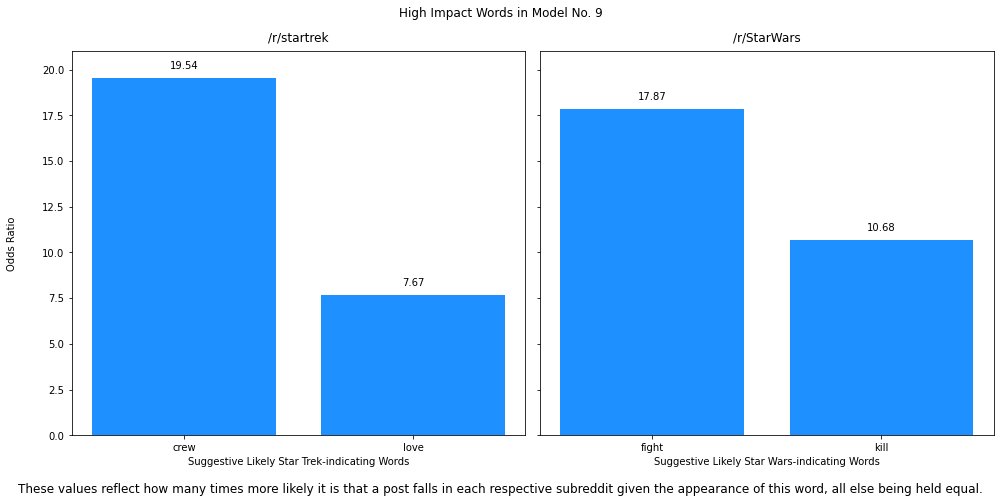

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,7), sharey = True)

plt.ylim(0,21)
plt.suptitle('High Impact Words in Model No. 9')
fig.supxlabel('These values reflect how many times more likely it is that a post falls\
 in each respective subreddit given the appearance of this word, all else being held equal.')
 
ax1.bar(impt_st['feature'], impt_st['odds_ratio_st'], color = 'dodgerblue')
ax1.set_ylabel('Odds Ratio', labelpad = 25)
ax1.set_xlabel('Suggestive Likely Star Trek-indicating Words')
ax1.set_title('/r/startrek', pad = 10)
ax1.text(0, impt_st.iloc[0]['odds_ratio_st']+.5, round(impt_st.iloc[0]['odds_ratio_st'], 2), ha = 'center')
ax1.text(1, impt_st.iloc[1]['odds_ratio_st']+.5, round(impt_st.iloc[1]['odds_ratio_st'], 2), ha = 'center')

ax2.bar(impt_sw['feature'], impt_sw['odds_ratio_sw'], color = 'dodgerblue')
ax2.set_title('/r/StarWars', pad = 10)
ax2.set_xlabel('Suggestive Likely Star Wars-indicating Words')
ax2.text(0, impt_sw.iloc[0]['odds_ratio_sw']+.5, round(impt_sw.iloc[0]['odds_ratio_sw'], 2), ha = 'center')
ax2.text(1, impt_sw.iloc[1]['odds_ratio_sw']+.5, round(impt_sw.iloc[1]['odds_ratio_sw'], 2), ha = 'center')

plt.tight_layout()
plt.savefig('images/impactful_words.png');